The dataset pertains to direct marketing campaigns of a Portuguese bank, where marketing was conducted via phone calls. Multiple contacts were often required to determine if a client would subscribe to a term deposit.

Instances: 45,211 (bank-full.csv) and 4,521 (bank.csv)
Attributes: 16 input variables + 1 output variable
Input Variables:

age: Numeric
job: Categorical (e.g., "admin", "student", "blue-collar")
marital: Categorical ("married", "divorced", "single")
education: Categorical ("unknown", "secondary", "primary", "tertiary")
default: Binary ("yes", "no")
balance: Numeric (average yearly balance in euros)
housing: Binary ("yes", "no")
loan: Binary ("yes", "no")
contact: Categorical ("unknown", "telephone", "cellular")
day: Numeric (last contact day of the month)
month: Categorical ("jan" to "dec")
duration: Numeric (last contact duration in seconds)
campaign: Numeric (number of contacts in this campaign)
pdays: Numeric (days since last contact; -1 indicates no previous contact)
previous: Numeric (number of previous contacts)
poutcome: Categorical ("unknown", "other", "failure", "success")
Output Variable:
y: Binary ("yes", "no") - Indicates whether the client subscribed to a term deposit

Analysis Performed: Campaign effectiveness, loan analysis, financial, and demographic analysis.

In [0]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
from pyspark.sql.functions import col, regexp_replace, sum, avg
from pyspark.sql.functions import *

import matplotlib.pyplot as plt
import seaborn as sns


In [0]:
spark = SparkSession.builder.appName("bank_app").getOrCreate()


data = spark.read \
    .format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("/FileStore/tables/bank_full.csv")  

data.show(2)

+---+----------+-------+---------+-------+-------+-------+----+-------+----+-----+--------+--------+-----+--------+-------+-----+
|age|       job|marital|education|default|balance|housing|loan|contact|day9|month|duration|campaign|pdays|previous|outcome|day16|
+---+----------+-------+---------+-------+-------+-------+----+-------+----+-----+--------+--------+-----+--------+-------+-----+
| 58|management|married| tertiary|     no|   2143|    yes|  no|unknown|   5|  may|     261|       1|   -1|       0|unknown|   no|
| 44|technician| single|secondary|     no|     29|    yes|  no|unknown|   5|  may|     151|       1|   -1|       0|unknown|   no|
+---+----------+-------+---------+-------+-------+-------+----+-------+----+-----+--------+--------+-----+--------+-------+-----+
only showing top 2 rows



In [0]:
age_group_expr = when(col('age').between(18, 30), '18-30') \
    .when(col('age').between(31, 50), '31-50') \
    .when(col('age').between(51, 70), '51-70') \
    .otherwise('71+')

data = data.withColumn('age_group', age_group_expr)

data.show(2)

+---+----------+-------+---------+-------+-------+-------+----+-------+----+-----+--------+--------+-----+--------+-------+-----+---------+
|age|       job|marital|education|default|balance|housing|loan|contact|day9|month|duration|campaign|pdays|previous|outcome|day16|age_group|
+---+----------+-------+---------+-------+-------+-------+----+-------+----+-----+--------+--------+-----+--------+-------+-----+---------+
| 58|management|married| tertiary|     no|   2143|    yes|  no|unknown|   5|  may|     261|       1|   -1|       0|unknown|   no|    51-70|
| 44|technician| single|secondary|     no|     29|    yes|  no|unknown|   5|  may|     151|       1|   -1|       0|unknown|   no|    31-50|
+---+----------+-------+---------+-------+-------+-------+----+-------+----+-----+--------+--------+-----+--------+-------+-----+---------+
only showing top 2 rows



In [0]:
data = data.drop('pdays', 'previous', 'outcome', 'day16', 'day9', 'age')

In [0]:
data.printSchema()

root
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- age_group: string (nullable = false)



In [0]:
data.describe().show()

+-------+-------+--------+---------+-------+------------------+-------+-----+--------+-----+-----------------+-----------------+---------+
|summary|    job| marital|education|default|           balance|housing| loan| contact|month|         duration|         campaign|age_group|
+-------+-------+--------+---------+-------+------------------+-------+-----+--------+-----+-----------------+-----------------+---------+
|  count|  45211|   45211|    45211|  45211|             45211|  45211|45211|   45211|45211|            45211|            45211|    45211|
|   mean|   NULL|    NULL|     NULL|   NULL|1362.2720576850766|   NULL| NULL|    NULL| NULL|258.1630797814691|2.763840658246887|     NULL|
| stddev|   NULL|    NULL|     NULL|   NULL|3044.7658291685257|   NULL| NULL|    NULL| NULL|257.5278122651706|3.098020883279192|     NULL|
|    min| admin.|divorced|  primary|     no|             -8019|     no|   no|cellular|  apr|                0|                1|    18-30|
|    max|unknown|  single| 

In [0]:
data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]).show()

+---+-------+---------+-------+-------+-------+----+-------+-----+--------+--------+---------+
|job|marital|education|default|balance|housing|loan|contact|month|duration|campaign|age_group|
+---+-------+---------+-------+-------+-------+----+-------+-----+--------+--------+---------+
|  0|      0|        0|      0|      0|      0|   0|      0|    0|       0|       0|        0|
+---+-------+---------+-------+-------+-------+----+-------+-----+--------+--------+---------+



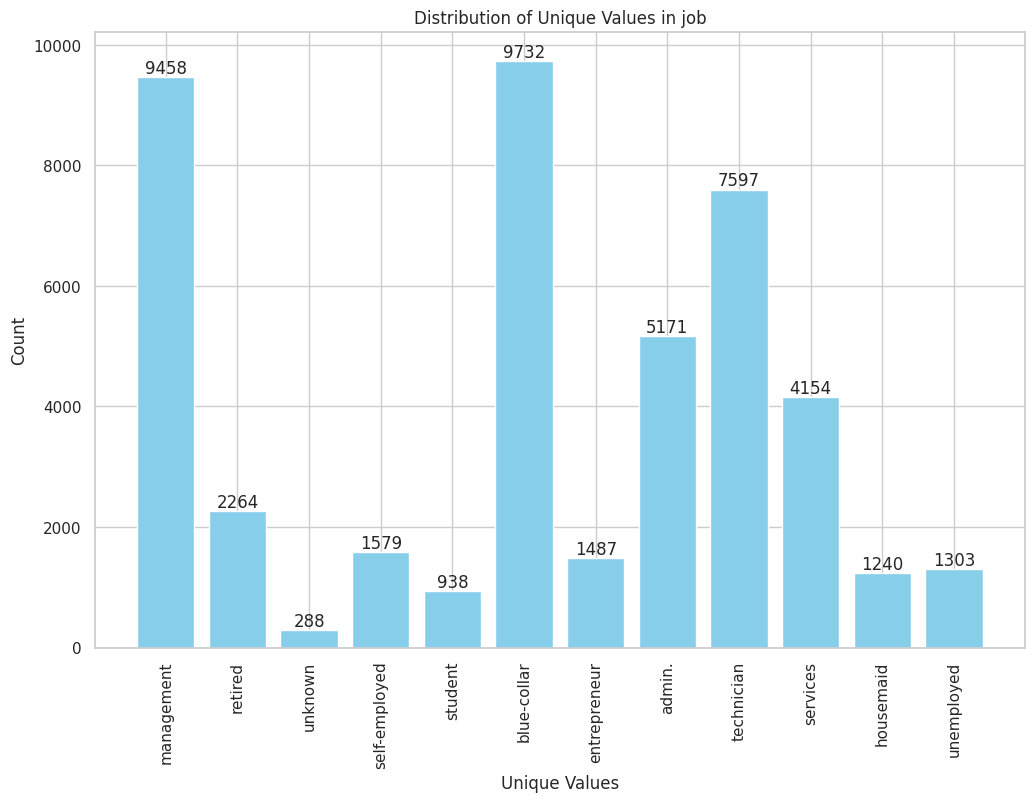

In [0]:
job_unique_counts = data.groupBy('job').count().toPandas()

plt.figure(figsize=(12, 8))
bar_job = plt.bar(job_unique_counts['job'].astype(str), job_unique_counts['count'], color='skyblue')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Distribution of Unique Values in job')
plt.xticks(rotation=90) 
for bar in bar_job:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

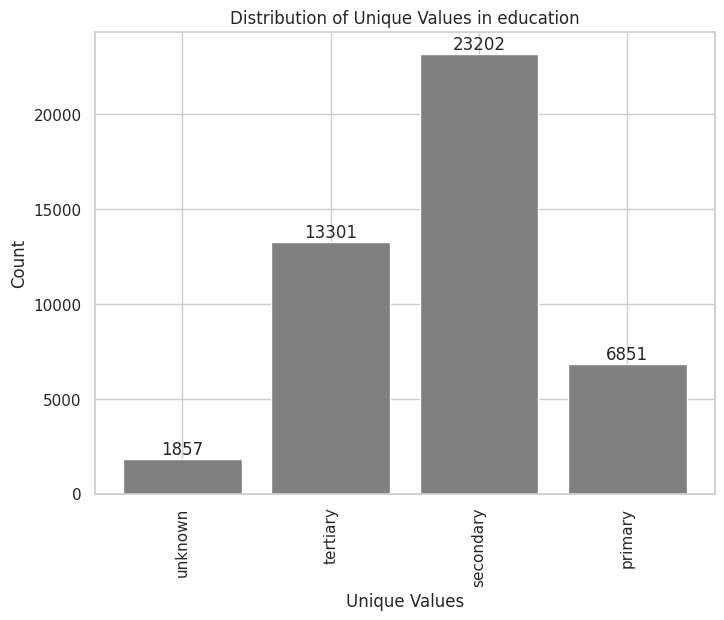

In [0]:
education_unique_counts = data.groupBy('education').count().toPandas()

plt.figure(figsize=(8, 6))
edu_bar = plt.bar(education_unique_counts['education'].astype(str), education_unique_counts['count'], color='gray')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Distribution of Unique Values in education')
plt.xticks(rotation=90)
for bar in edu_bar:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

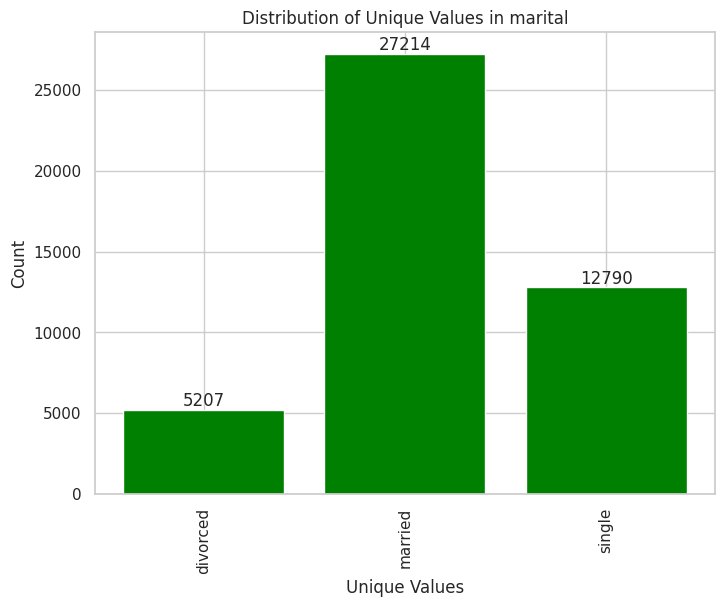

In [0]:
marital_unique_counts = data.groupBy('marital').count().toPandas()

plt.figure(figsize=(8, 6))
marital_bar = plt.bar(marital_unique_counts['marital'].astype(str), marital_unique_counts['count'], color='green')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Distribution of Unique Values in marital')
plt.xticks(rotation=90)
for bar in marital_bar:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

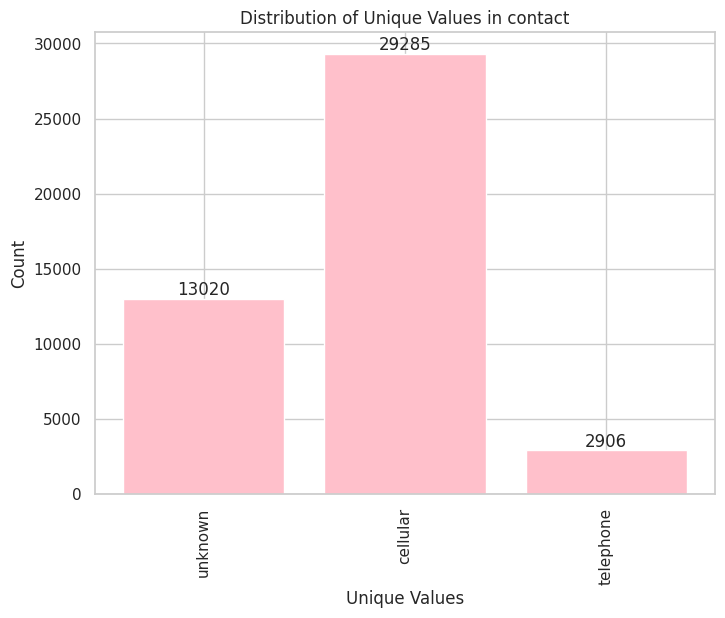

In [0]:
war = data.groupBy('contact').count().toPandas()

plt.figure(figsize=(8, 6))
bar_default = plt.bar(war['contact'].astype(str), war['count'], color='pink')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Distribution of Unique Values in contact')
plt.xticks(rotation=90)
for bar in bar_default:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()


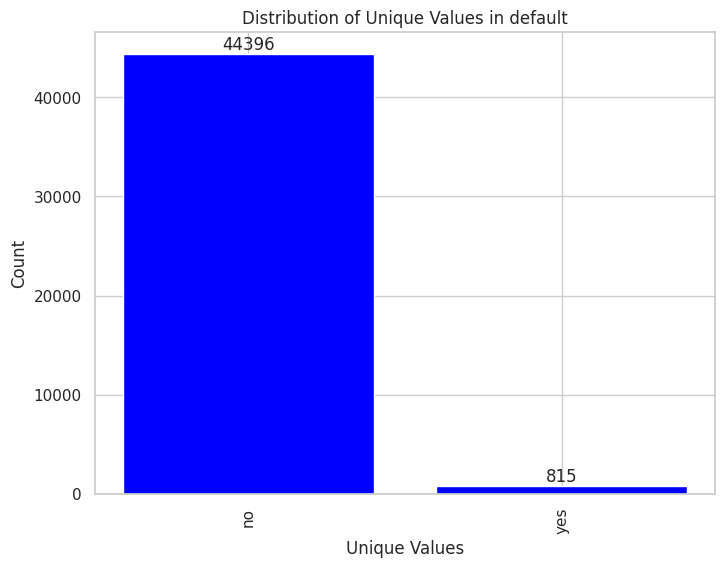

In [0]:
default_unique_counts = data.groupBy('default').count().toPandas()

plt.figure(figsize=(8, 6))
bar_default = plt.bar(default_unique_counts['default'].astype(str), default_unique_counts['count'], color='blue')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Distribution of Unique Values in default')
plt.xticks(rotation=90)
for bar in bar_default:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

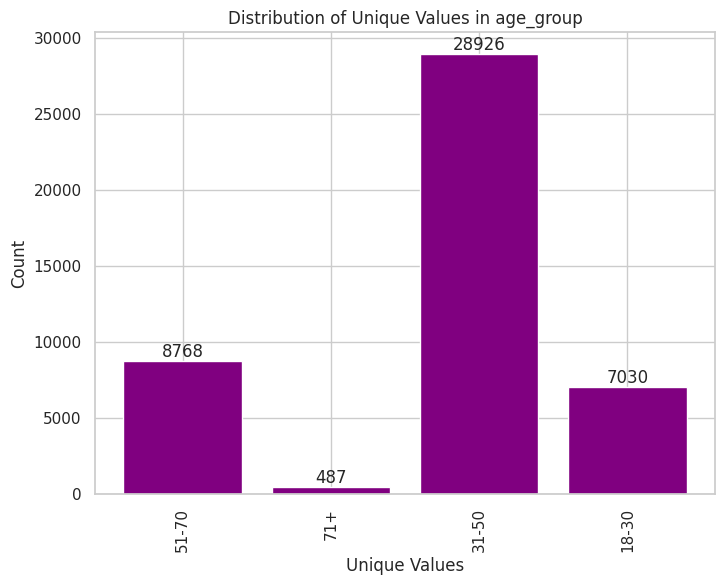

In [0]:
age_unique_counts = data.groupBy('age_group').count().toPandas()

plt.figure(figsize=(8, 6))
bars=plt.bar(age_unique_counts['age_group'].astype(str), age_unique_counts['count'], color='purple')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Distribution of Unique Values in age_group')
plt.xticks(rotation=90)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

In [0]:
data.createOrReplaceTempView("bank_app")

In [0]:

%sql
SELECT age_group, AVG(balance) AS avg_balance
FROM bank_app
GROUP BY age_group
ORDER BY avg_balance

age_group,avg_balance
18-30,1019.952773826458
31-50,1286.708013551822
51-70,1799.6809990875913
71+,2916.827515400411


Databricks visualization. Run in Databricks to view.

In [0]:
%sql
SELECT job, marital, education, COUNT(*) AS count
FROM bank_app
GROUP BY job, marital, education
ORDER BY job, marital, education
LIMIT  4

job,marital,education,count
admin.,divorced,primary,30
admin.,divorced,secondary,648
admin.,divorced,tertiary,54
admin.,divorced,unknown,18


In [0]:
%sql
CREATE OR REPLACE TEMP VIEW count_job AS
SELECT job, marital, education, COUNT(*) AS count
FROM bank_app
GROUP BY job, marital, education
ORDER BY job, marital, education;

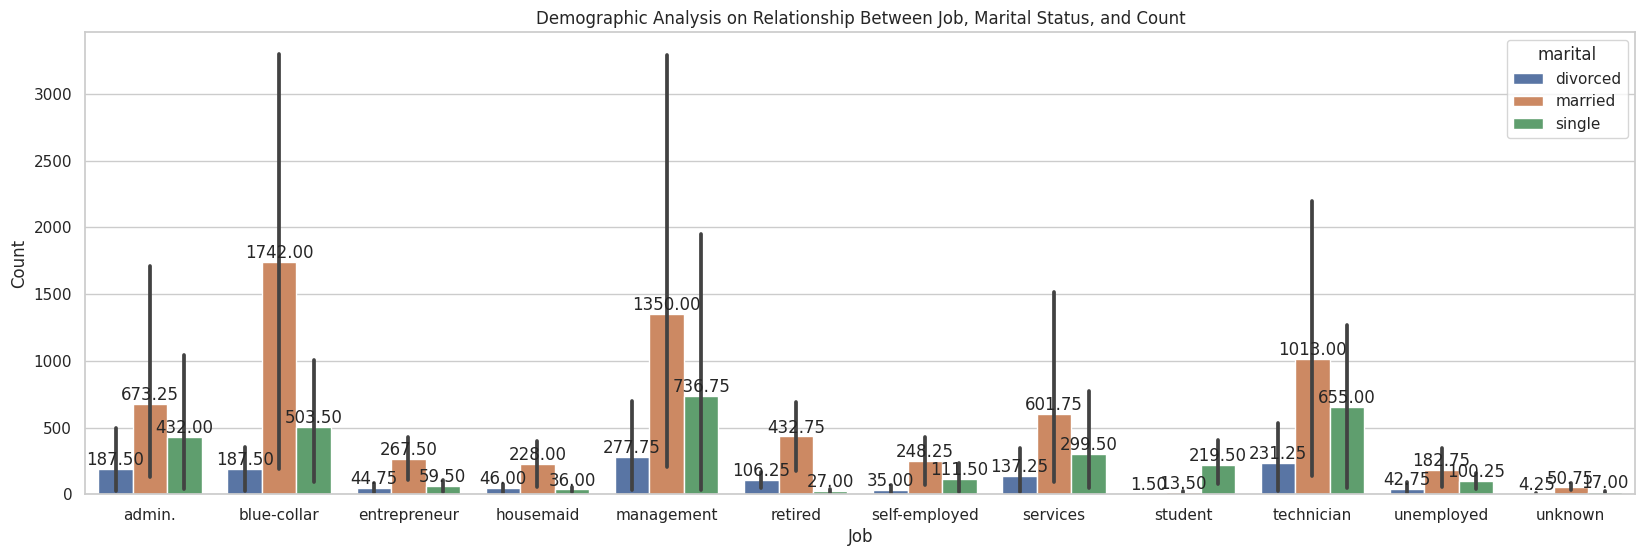

In [0]:
result_df = spark.table("count_job").toPandas()

plt.figure(figsize=(20, 6))
job_across = sns.barplot(x='job', y='count', hue='marital', data=result_df)

plt.title('Demographic Analysis on Relationship Between Job, Marital Status, and Count')
plt.xlabel('Job')
plt.ylabel('Count')

for bar in job_across.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2f}', 
        ha='center',
        va='bottom'
    )

plt.show()

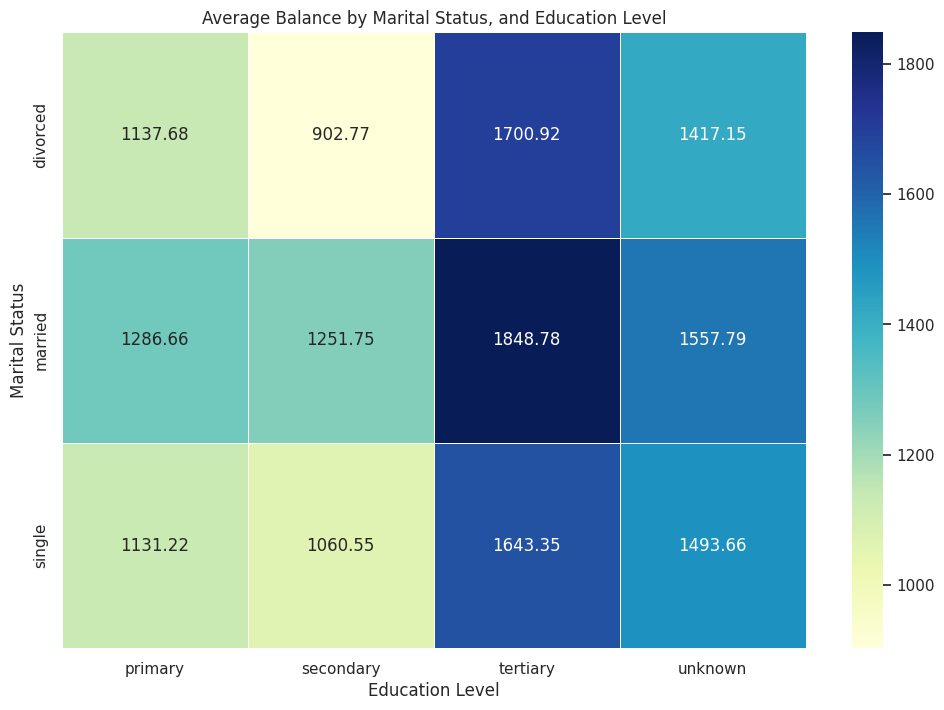

In [0]:
sql_query = """
SELECT
    marital,
    education,
    AVG(balance) AS avg_balance
FROM
    bank_app
GROUP BY
    marital,
    education
ORDER BY
    marital,
    education
"""

financial = spark.sql(sql_query).toPandas()

heatmap_data = financial.pivot_table(index=['marital'], columns='education', values='avg_balance')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
plt.title('Average Balance by Marital Status, and Education Level')
plt.xlabel('Education Level')
plt.ylabel('Marital Status')
plt.show()


In [0]:
%sql
SELECT 
    default, 
    AVG(balance) AS avg_balance
FROM 
    bank_app
GROUP BY 
    default;


default,avg_balance
no,1389.8064240021624
yes,-137.6245398773006


Databricks visualization. Run in Databricks to view.

In [0]:
%sql
SELECT 
    default, 
    AVG(CAST(housing = 'yes' AS INT)) AS proportion_housing_loan
FROM 
    bank_app
GROUP BY 
    default;


default,proportion_housing_loan
no,0.5562438057482656
yes,0.5337423312883436


Databricks visualization. Run in Databricks to view.

In [0]:
%sql
SELECT 
    default, 
    AVG(CAST(loan = 'yes' AS INT)) AS proportion_personal_loan
FROM 
    bank_app
GROUP BY 
    default;


default,proportion_personal_loan
no,0.15638796287953868
yes,0.3693251533742331


Databricks visualization. Run in Databricks to view.

In [0]:
%sql
select marital, count(default) AS count_default
from bank_app
group by marital
ORDER BY count_default

marital,count_default
divorced,5207
single,12790
married,27214


Databricks visualization. Run in Databricks to view.

In [0]:
%sql
SELECT age_group, education, COUNT(*) as count
FROM bank_app
GROUP BY age_group, education
ORDER BY age_group, education


age_group,education,count
18-30,primary,513
18-30,secondary,4120
18-30,tertiary,2160
18-30,unknown,237
31-50,primary,4010
31-50,secondary,15007
31-50,tertiary,8893
31-50,unknown,1016
51-70,primary,2111
51-70,secondary,3943


Databricks visualization. Run in Databricks to view.

In [0]:
%sql
SELECT 
    contact,
    SUM(campaign) AS total_current_campaign_contacts
FROM 
    bank_app
GROUP BY 
    contact;



contact,total_current_campaign_contacts
unknown,36293
cellular,78780
telephone,9883


Databricks visualization. Run in Databricks to view.